In [1]:
# This file is part of PyLPbounds
# Copyright © 2021 Huawei or/and its subsidiary(-ies). All right reserved
# Author: 
#       Anne Bouillard <anne.bouillard@huawei.com>

## Blind multiplexing: comparison of methods

WE consider the simple case of tandem networks of differnt length  and cross traffic haing paths f different lenhts two (uniform for the tandem), and compare with different mathods: 

- SFA purely blind
- SFA with pioritie, since it has been povd that thw static priority SDF (shortest to destination first) is the worst scheduling
- PMOO
- LP (linear programming techniques)

As expected, they are listed from the worst to best approach

In [2]:
import numpy as np
import random as rd
import matplotlib
import matplotlib.pyplot as plt
import pickle


from panco.descriptor.curves import TokenBucket, RateLatency
from panco.descriptor.flow import Flow
from panco.descriptor.server import Server
from panco.descriptor.network import Network, reindexing
from panco.fifo.tfaLP import TfaLP
from panco.fifo.fifoLP import FifoLP
from panco.blind.blindLP import BlindLP

In [3]:
def sfa_analysis(network: Network, foi):
    residual_rate = np.inf * np.ones(network.num_flows)
    residual_latency = np.zeros(network.num_flows)
    sigma = [network.flows[i].arrival_curve[0].sigma for i in range(network.num_flows)]
    for j in range(network.num_servers):
        tot_rho = sum([network.flows[i].arrival_curve[0].rho for i in network.flows_in_server[j]])
        tot_sigma = sum([sigma[i] for i in network.flows_in_server[j]])
        # print(tot_sigma)
        rate = network.servers[j].service_curve[0].rate
        latency = network.servers[j].service_curve[0].latency
        for i in network.flows_in_server[j]:
            residual_rate[i] = min(residual_rate[i], 
                                   rate - tot_rho + 
                                      network.flows[i].arrival_curve[0].rho)
            cur_lat = (tot_sigma - network.flows[i].arrival_curve[0].sigma + 
                                    rate * latency)/ (rate - tot_rho + network.flows[i].arrival_curve[0].rho)
            residual_latency[i] += cur_lat
            sigma[i] += network.flows[i].arrival_curve[0].rho * cur_lat
    delay = []
    for i in range(network.num_flows):
        delay += [residual_latency[i] + network.flows[i].arrival_curve[0].sigma / residual_rate[i]]
    return delay[foi]

In [4]:
def sfa_prio_analysis(network: Network, foi):
    residual_rate = np.inf * np.ones(network.num_flows)
    residual_latency = np.zeros(network.num_flows)
    sigma = [network.flows[i].arrival_curve[0].sigma for i in range(network.num_flows)]
    for j in range(network.num_servers):
        tot_rho = sum([network.flows[i].arrival_curve[0].rho for i in network.flows_in_server[j]])
        tot_sigma = sum([sigma[i] for i in network.flows_in_server[j]])
        # print(tot_sigma)
        rate = network.servers[j].service_curve[0].rate
        latency = network.servers[j].service_curve[0].latency
        for i in network.flows_in_server[j]: 
            residual_rate_aux = rate - sum([network.flows[i].arrival_curve[0].rho 
                                            for k in network.flows_in_server[j] if k > i])
            residual_rate[i] = min(residual_rate[i], residual_rate_aux)
            sigma_aux = sum([sigma[k] for k in network.flows_in_server[j] if k > i])
            cur_lat = (sigma_aux + rate * latency)/ (residual_rate_aux)
            residual_latency[i] += cur_lat
            sigma[i] += network.flows[i].arrival_curve[0].rho * cur_lat
    delay = []
    for i in range(network.num_flows):
        delay += [residual_latency[i] + network.flows[i].arrival_curve[0].sigma / residual_rate[i]]
    return delay[foi]

In [5]:
def pmoo_analysis(network:Network, foi):
    if not network.is_tree:
        raise Exception('not a tree')
    res_rates = []
    arr_rates = []
    for j in range(network.num_servers):
        r = sum([network.flows[i].arrival_curve[0].rho for i in network.flows_in_server[j] if not i == foi])
        arr_rates += [r]
        res_rates += [network.servers[j].service_curve[0].rate - r]
    residual_rate = min(res_rates)
    latency = sum([network.servers[j].service_curve[0].latency * (1 + arr_rates[j] / residual_rate) 
                   for j in range(network.num_servers)]) + \
              sum([network.flows[i] .arrival_curve[0].sigma 
                   for i in range(network.num_flows) if not i == foi]) / residual_rate
    return latency + network.flows[foi].arrival_curve[0].sigma / residual_rate

In [39]:
N = 51
R1 = 10000000.
R2 = 20000000.
L = 0.001
S = 1000.
K = 1
U = 0.9

NETWORK_LIST = []
SC1 = RateLatency(R1, L)
MSC1 = TokenBucket(0, K * R1)
SC2 = RateLatency(R2, L)
MSC2 = TokenBucket(0, K * R2)
AC = TokenBucket(S, U * R1 / 4)
SERVER1 = Server([SC1], [MSC1])
SERVER2 = Server([SC2], [MSC2])
for n in range(1, N):
    PATH = [[i for i in range(n)]] + [[i, i + 1, i + 2, i + 3] for i in range(n - 3)]
    FLOWS = [Flow([AC], p) for p in PATH]
    SERVERS = []
    for j in range(n):
        if j % 2 == 0:
            SERVERS += [SERVER1]
        else:
            SERVERS += [SERVER2]
    NETWORK_LIST +=  [(n, Network(SERVERS, FLOWS))]

In [40]:
d_sfa = []
d_sfa_sdf = []
d_pmoo = []
d_lp = []
for (n, network) in NETWORK_LIST:
    d_sfa +=[sfa_analysis(network, 0)]
    d_sfa_sdf += [sfa_prio_analysis(network, 0)]
    d_pmoo += [pmoo_analysis(network, 0)]
    d_lp += [BlindLP(network).delay(0)]
    print(n, "\t", sfa_analysis(network, 0), "\t", sfa_prio_analysis(network, 0), "\t", 
          pmoo_analysis(network, 0), "\t", BlindLP(network).delay(0))
    

1 	 0.0011 	 0.0011 	 0.0011 	 0.0011
2 	 0.0022124999999999996 	 0.0021 	 0.0021 	 0.0021
3 	 0.0036878124999999997 	 0.0031 	 0.0031 	 0.0031
4 	 0.008960720633985501 	 0.006421626533393913 	 0.005419354838709678 	 0.005255792258064516
5 	 0.02316831856262362 	 0.011214764416600825 	 0.008818181818181819 	 0.008335118181818183
6 	 0.06509219263529249 	 0.018711389508025686 	 0.01553846153846154 	 0.013378212307692308
7 	 0.19068918275626842 	 0.02687980870381582 	 0.019615384615384614 	 0.017980392307692307
8 	 1.0140190996293186 	 0.05338711195170485 	 0.059 	 0.04397599
9 	 2.8989940762367037 	 0.061555531147494985 	 0.07 	 0.048578170000000004
10 	 15.376495854636898 	 0.08737052670307632 	 0.081 	 0.06470839
11 	 43.88741087847576 	 0.09553894589886644 	 0.092 	 0.06931057
12 	 232.65352497313526 	 0.12135394145444778 	 0.103 	 0.08544078
13 	 663.928072151822 	 0.1295223606502379 	 0.114 	 0.09004296
14 	 3519.3679706213916 	 0.15533735620581923 	 0.125 	 0.10617318
15 	 10043.1

[]

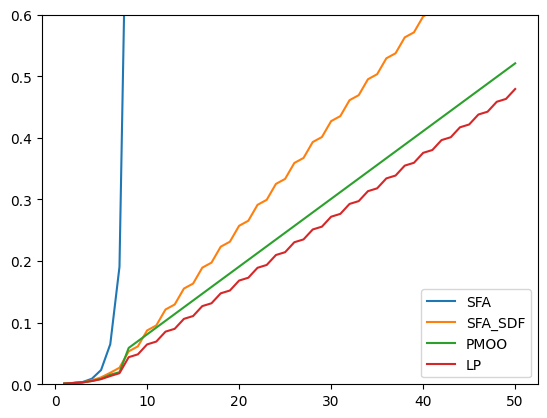

In [42]:
plt.plot(range(1, N), d_sfa, label='SFA')
plt.plot(range(1, N), d_sfa_sdf, label='SFA_SDF')
plt.plot(range(1, N), d_pmoo, label='PMOO')
plt.plot(range(1, N), d_lp, label='LP')
plt.ylim([0, 0.6])
plt.legend()
plt.plot()

In [ ]:
NOte that for a small number of flows, PMOO is not better than SFA-SDF, and that all for a tandem of lengh 50, the omputation time
is 